         Provinsi  Petani Tanaman Pangan  Petani Hortikultura  \
0            ACEH                  -4.43                 4.72   
1  SUMATERA UTARA                  -2.51                 1.89   
2  SUMATERA BARAT                  -4.29                33.79   
3            RIAU                  -1.90                -1.13   
4           JAMBI                  -4.01                15.83   

   Petani Tanaman Perkebunan  Petani Peternakan  Petani Ikan  y_biner  
0                      19.97               2.58        -0.62        1  
1                      37.04              -0.91        -0.10        0  
2                      39.49               1.10         2.20        1  
3                      43.15               2.54        -0.35        0  
4                      36.13               2.36         1.33        1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------        

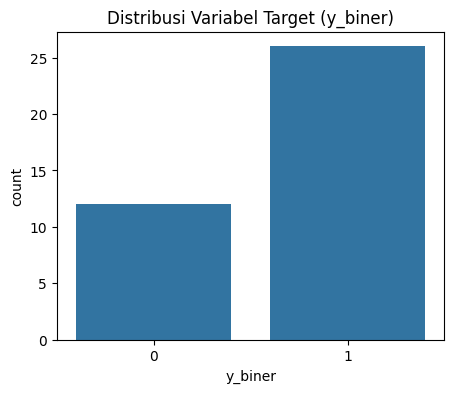

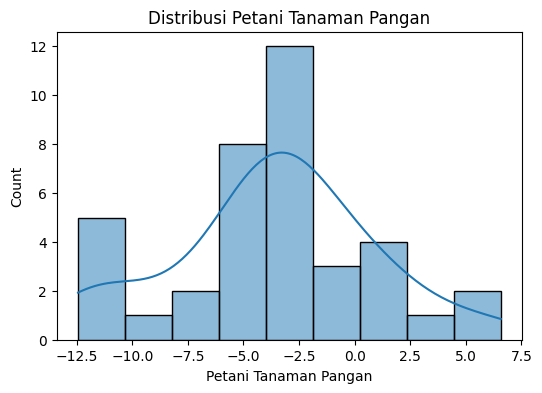

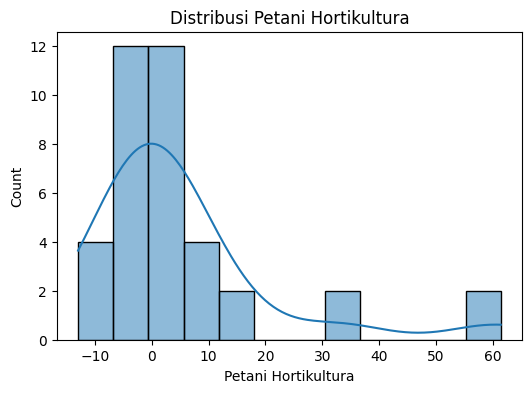

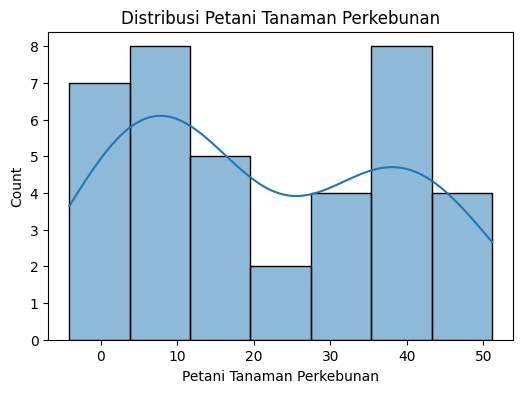

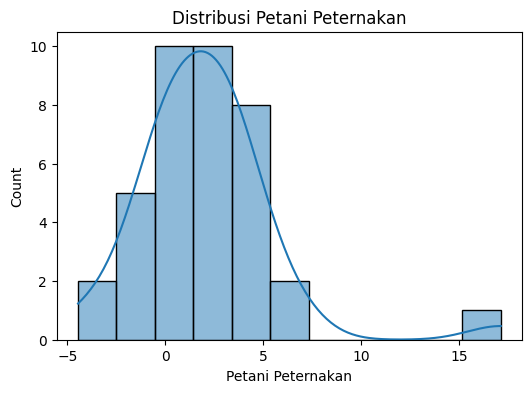

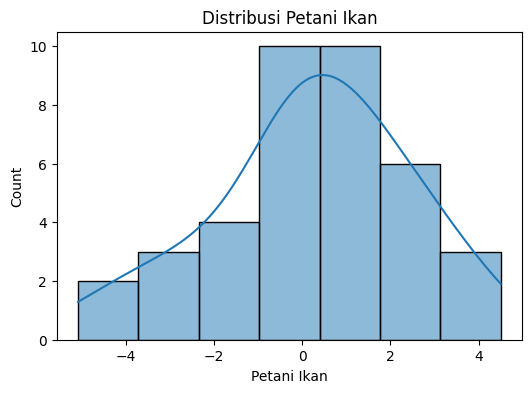

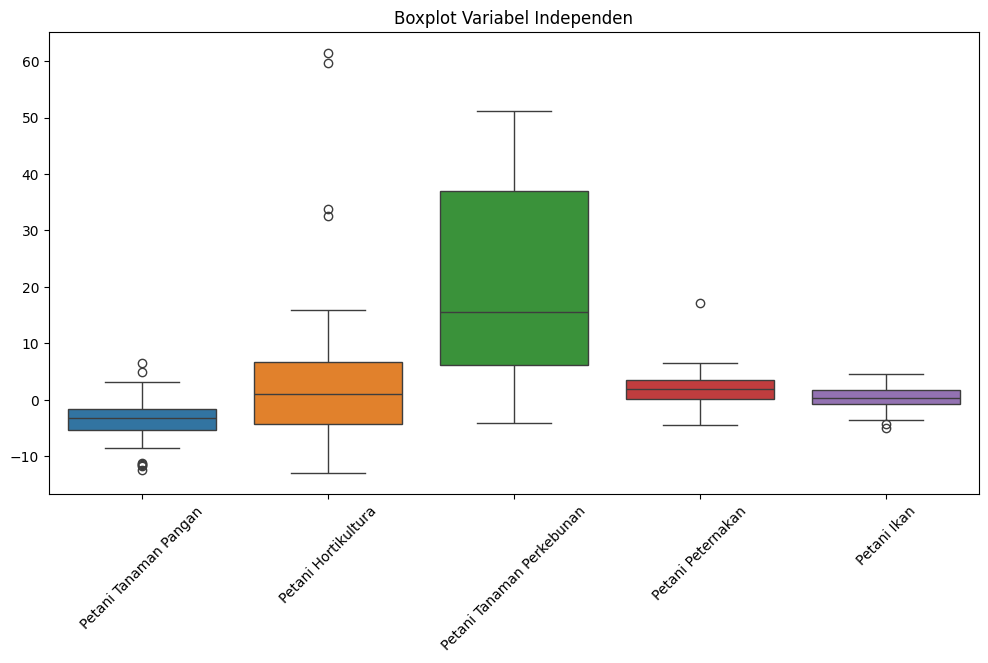

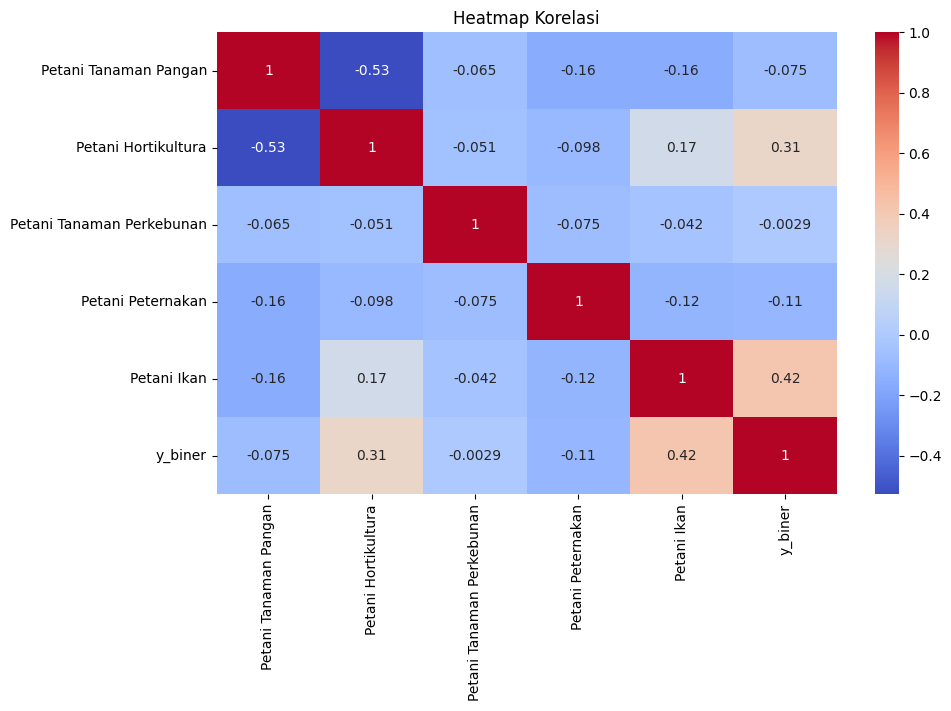

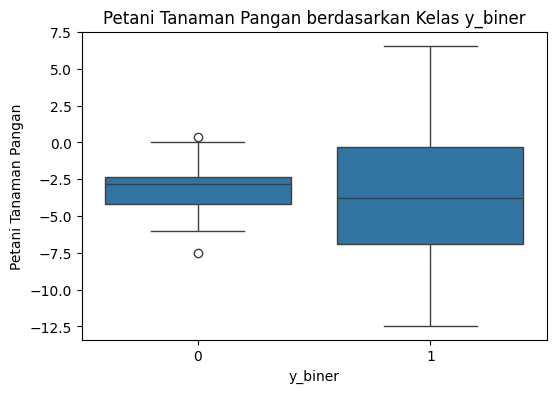

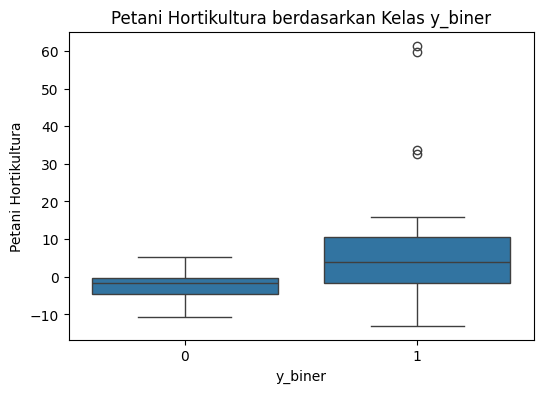

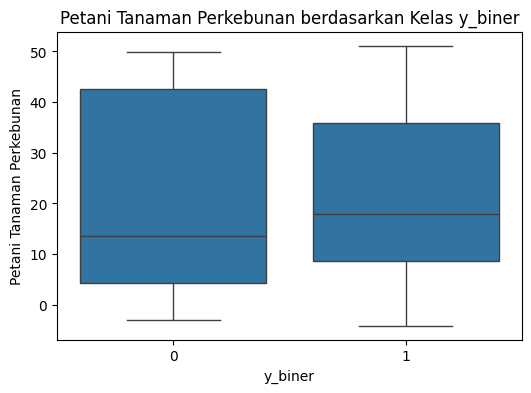

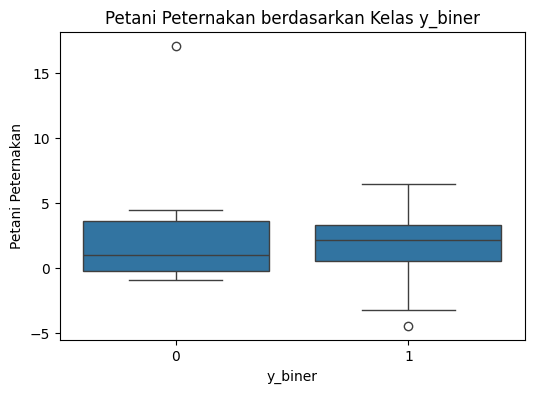

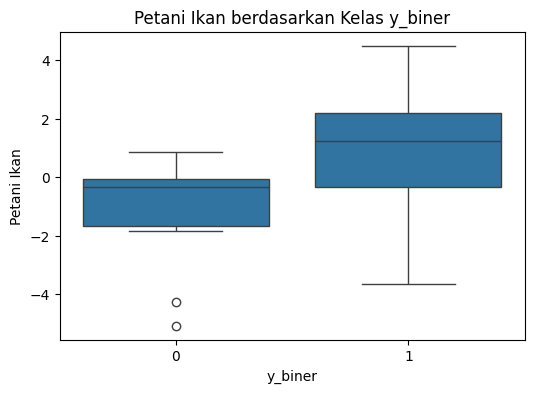

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ========================
# 1. LOAD DATA
# ========================

df = pd.read_csv("data_ntp.csv")

# ========================
# 2. CEK STRUKTUR DATA
# ========================

print(df.head())
print(df.info())
print(df.describe())

# ========================
# 3. CEK MISSING VALUE
# ========================

print(df.isnull().sum())

# ========================
# 4. DISTRIBUSI TARGET
# ========================

plt.figure(figsize=(5,4))
sns.countplot(x="y_biner", data=df)
plt.title("Distribusi Variabel Target (y_biner)")
plt.show()

# ========================
# 5. DISTRIBUSI SETIAP VARIABEL X
# ========================

kolom_x = [
    "Petani Tanaman Pangan",
    "Petani Hortikultura",
    "Petani Tanaman Perkebunan",
    "Petani Peternakan",
    "Petani Ikan"
]

for kol in kolom_x:
    plt.figure(figsize=(6,4))
    sns.histplot(df[kol], kde=True)
    plt.title(f"Distribusi {kol}")
    plt.show()

# ========================
# 6. BOXPLOT (CARI OUTLIER)
# ========================

plt.figure(figsize=(12,6))
sns.boxplot(data=df[kolom_x])
plt.title("Boxplot Variabel Independen")
plt.xticks(rotation=45)
plt.show()

# ========================
# 7. HEATMAP KORELASI
# ========================

plt.figure(figsize=(10,6))
sns.heatmap(df[kolom_x + ["y_biner"]].corr(), annot=True, cmap="coolwarm")
plt.title("Heatmap Korelasi")
plt.show()

# ========================
# 8. PERBANDINGAN X BERDASARKAN y_biner
# ========================

for kol in kolom_x:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="y_biner", y=kol, data=df)
    plt.title(f"{kol} berdasarkan Kelas y_biner")
    plt.show()

In [5]:
# Nama kolom yang diharapkan (sesuaikan jika perlu)
COL_RAW = ['Petani Tanaman Pangan','Petani Hortikultura','Petani Tanaman Perkebunan','Petani Peternakan','Petani Ikan']
ID_COL = 'Provinsi'  # jika tidak punya, tetap boleh
X = df[COL_RAW].copy()
y = df['y_biner'].astype(int)

X.isna().sum()
y.isna().sum()
X.shape
y.shape


(38,)

In [6]:
X.isna().any(axis=1).sum()

np.int64(0)

In [11]:
# Analisis_Logistic_NTP.py
# Pemodelan: 1) Regresi Logistik Multivariat
#           2) Regresi Logistik dengan Polynomial (degree=2)
# Input: CSV berisi selisih NTP antar tahun untuk 5 subsektor per provinsi
# Kolom yang diharapkan (contoh nama):
# 'provinsi','ntp_tanaman_pangan','ntp_hortikultura','ntp_perkebunan','ntp_peternakan','ntp_ikan'
# Catatan: file 'data.csv' harus berada di folder yang sama; jika nama kolom berbeda, sesuaikan pada bagian 'COLUMN NAMES'

# ----- IMPORT LIBRARIES -----
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, accuracy_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# ---------------------------
# 1. PENGATURAN AWAL & LOAD DATA
# ---------------------------
DATA_PATH = 'data_ntp.csv'  # ganti sesuai lokasi file
# Nama kolom yang diharapkan (sesuaikan jika perlu)
COL_RAW = ['Petani Tanaman Pangan','Petani Hortikultura','Petani Tanaman Perkebunan','Petani Peternakan','Petani Ikan']
ID_COL = 'Provinsi'  # jika tidak punya, tetap boleh

# Baca file
df = pd.read_csv(DATA_PATH)
print('\n[INFO] Data berhasil dimuat. Ukuran data:', df.shape)

# Tampilkan 5 baris pertama
print(df.head())

# ---------------------------
# 2. PERIKSA MISSING VALUE & TYPE
# ---------------------------
print('\n[INFO] Ringkasan missing value per kolom:')
print(df[COL_RAW].isnull().sum())

print('\n[INFO] Tipe data:')
print(df[COL_RAW].dtypes)

# Pilihan strategi missing value: 'drop', 'median', 'mean'
MISSING_STRATEGY = 'median'

if df[COL_RAW].isnull().any().any():
    if MISSING_STRATEGY == 'drop':
        df = df.dropna(subset=COL_RAW)
        print('\n[INFO] Baris dengan missing value pada kolom subsektor di-drop.')
    else:
        imputer = SimpleImputer(strategy=MISSING_STRATEGY)
        df[COL_RAW] = imputer.fit_transform(df[COL_RAW])
        print(f"\n[INFO] Missing values diimput menggunakan strategi: {MISSING_STRATEGY}.")
else:
    print('\n[INFO] Tidak ada missing value pada kolom subsektor.')

# ---------------------------
# 4. FITUR (X) & STANDARISASI
# ---------------------------
X = df[COL_RAW].copy()
y = df['y_biner'].astype(int)

# Standarisasi fitur (opsional, direkomendasikan untuk model dengan regularisasi)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=COL_RAW)

# ---------------------------
# 5. CEK MULTIKOLINEARITAS (VIF)
# ---------------------------
# Untuk VIF, tambahkan constant
X_vif = sm.add_constant(X_scaled)
vif_data = pd.DataFrame()
vif_data['feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print('\n[INFO] VIF setiap variabel (termasuk konstanta):')
print(vif_data)

# Jika VIF untuk fitur > 5 atau >10, pertimbangkan penghapusan / kombinasi fitur / PCA.

# ---------------------------
# 6. SIAPKAN TRAIN-TEST SPLIT
# ---------------------------
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)
print('\n[INFO] Split data. Training:', X_train.shape, ' Testing:', X_test.shape)

# ---------------------------
# 7. MODEL 1: REGRESI LOGISTIK MULTIVARIAT (tanpa polynomial)
#    - Gunakan statsmodels untuk ringkasan koefisien dan uji serentak (LLR)
# ---------------------------
# TANPA train-test split untuk inferensi
X_sm = sm.add_constant(X_scaled)
logit_model_1 = sm.Logit(y, X_sm).fit(disp=False)

print(logit_model_1.summary())

print('\n[MODEL 1] Ringkasan hasil (Logit multivariat):')
print(logit_model_1.summary())

# Simpan prediksi probabilitas pada test set
X_test_sm = sm.add_constant(X_test)
probs1 = logit_model_1.predict(X_test_sm)
preds1 = (probs1 >= 0.5).astype(int)

#OODS RATIO
odds_ratio = np.exp(logit_model_1.params)
print('\n[ODDS RATIO]')
print(odds_ratio)

# Evaluasi dasar
print('\n[MODEL 1] Evaluasi pada test set:')
print('AUC:', roc_auc_score(y_test, probs1))
print('Accuracy:', accuracy_score(y_test, preds1))
print(classification_report(y_test, preds1))
print('Confusion matrix:\n', confusion_matrix(y_test, preds1))

# ---------------------------
# 8. MODEL 2: REGRESI LOGISTIK DENGAN POLYNOMIAL (degree=2)
#    - Buat polynomial features (termasuk interaksi dan kuadrat)
# ---------------------------
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
X_poly = poly.fit_transform(X_scaled)
poly_feature_names = poly.get_feature_names_out(COL_RAW)
X_poly_df = pd.DataFrame(X_poly, columns=poly_feature_names)

# Standarisasi kembali (sudah terstandar sebelumnya, tapi polynomial bisa berubah skala) -> standar lagi
X_poly_scaled = pd.DataFrame(scaler.fit_transform(X_poly_df), columns=poly_feature_names)

# Split
X2_train, X2_test, y2_train, y2_test = train_test_split(X_poly_scaled, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

# Fit model menggunakan statsmodels untuk ringkasan
X2_train_sm = sm.add_constant(X2_train)
# Jika jumlah fitur terlalu besar sehingga statsmodels gagal (singular), pertimbangkan regularized sklearn LogisticRegression
try:
    logit_model_2 = sm.Logit(y2_train, X2_train_sm).fit(disp=False)
    print('\n[MODEL 2] Ringkasan hasil (Logit polynomial):')
    print(logit_model_2.summary())
    X2_test_sm = sm.add_constant(X2_test)
    probs2 = logit_model_2.predict(X2_test_sm)
    preds2 = (probs2 >= 0.5).astype(int)
except Exception as e:
    print('\n[WARNING] Gagal fitting statsmodels untuk model polynomial (kemungkinan multikolinearitas atau banyak fitur).\n         Menggunakan sklearn LogisticRegression (penalized) sebagai alternatif.')
    clf = LogisticRegression(max_iter=10000, penalty='l2', solver='liblinear')
    clf.fit(X2_train, y2_train)
    probs2 = clf.predict_proba(X2_test)[:,1]
    preds2 = (probs2 >= 0.5).astype(int)

# Evaluasi model 2
print('\n[MODEL 2] Evaluasi pada test set:')
print('AUC:', roc_auc_score(y_test, probs2))
print('Accuracy:', accuracy_score(y_test, preds2))
print(classification_report(y_test, preds2))
print('Confusion matrix:\n', confusion_matrix(y_test, preds2))

# ---------------------------
# 9. UJI SERENTAK (LIKELIHOOD RATIO TEST)
#    - Bandingkan model 1 (restricted) vs model 2 (full) -> H0: model restricted cukup
# ---------------------------
# Jika kedua model di-fit pakai statsmodels, kita bisa pakai -2*(LL_restricted - LL_full)
try:
    llf1 = logit_model_1.llf
    llf2 = logit_model_2.llf
    lr_stat = -2 * (llf1 - llf2)
    df_diff = logit_model_2.df_model - logit_model_1.df_model
    p_value_lr = stats.chi2.sf(lr_stat, df_diff)
    print('\n[LIKELIHOOD RATIO TEST]')
    print('LR stat:', lr_stat, ' df:', df_diff, ' p-value:', p_value_lr)
except Exception:
    print('\n[LIKELIHOOD RATIO TEST] Tidak dapat dihitung dengan statsmodels (salah satu model pakai sklearn).')
    # Alternatif: fitting sklearn models and use sklearn's log loss comparison or compare AIC/BIC if available.

# ---------------------------
# 10. GOODNESS OF FIT - HOSMER-LEMESHOW TEST
# ---------------------------
def hosmer_lemeshow_test(y_true, y_prob, groups=10):
    # Mengelompokkan probabilitas ke decile
    data = pd.DataFrame({'y': y_true, 'prob': y_prob})
    data['decile'] = pd.qcut(data['prob'], groups, duplicates='drop')
    obs = data.groupby('decile')['y'].sum()
    exp = data.groupby('decile')['prob'].sum()
    n = data.groupby('decile')['y'].count()
    hl_stat = (((obs - exp) ** 2) / (exp * (1 - exp / n))).replace([np.inf, -np.inf], 0).sum()
    p_value = 1 - stats.chi2.cdf(hl_stat, groups - 2)
    return hl_stat, p_value

hl1, p1 = hosmer_lemeshow_test(y_test.reset_index(drop=True), probs1.reset_index(drop=True), groups=10)
print('\n[HOSMER-LEMESHOW] Model 1: HL stat =', hl1, ' p-value =', p1)
hl2, p2 = hosmer_lemeshow_test(y_test.reset_index(drop=True), pd.Series(probs2).reset_index(drop=True), groups=10)
print('[HOSMER-LEMESHOW] Model 2: HL stat =', hl2, ' p-value =', p2)

# Interpretasi singkat:
print('\n[INTERPRETASI HL] Jika p-value besar (>0.05), tidak ada bukti kuat terhadap poor fit. Jika p-value kecil (<=0.05), model mungkin tidak fit dengan baik.')

# ---------------------------
# 11. PERBANDINGAN MODEL & REKOMENDASI
# ---------------------------
print('\n[PERBANDINGAN RINGKAS]')
print('Model 1: AIC, BIC, LL jika tersedia:')
try:
    print('AIC:', logit_model_1.aic, ' BIC:', logit_model_1.bic, ' LLF:', logit_model_1.llf)
except Exception:
    pass

try:
    print('Model 2: AIC, BIC, LL jika tersedia:')
    print('AIC:', logit_model_2.aic, ' BIC:', logit_model_2.bic, ' LLF:', logit_model_2.llf)
except Exception:
    pass

print('\nBandingkan AUC, Accuracy, Likelihood Ratio Test p-value, Hosmer-Lemeshow p-value. Pilih model terbaik berdasarkan kombinasi:')
print('- Signifikansi koefisien (uji individual)')
print('- Uji serentak (LR test) untuk melihat apakah polynomial signifikan menambah penjelasan')
print('- AIC/BIC: nilai lebih kecil lebih baik')
print('- AUC: lebih tinggi lebih baik')
print('- Goodness-of-fit (Hosmer-Lemeshow): p-value > 0.05 menandakan fit yang wajar')

# ---------------------------
# 12. SIMPAN MODEL & HASIL (opsional)
# ---------------------------
df.to_csv('data_processed.csv', index=False)
hasil = df.copy()
hasil['prob_model1'] = np.nan
hasil.loc[X_test.index, 'prob_model1'] = probs1
hasil.to_csv('hasil_prediksi.csv', index=False)

print('\n[SELESAI] Script selesai.')


[INFO] Data berhasil dimuat. Ukuran data: (38, 7)
         Provinsi  Petani Tanaman Pangan  Petani Hortikultura  \
0            ACEH                  -4.43                 4.72   
1  SUMATERA UTARA                  -2.51                 1.89   
2  SUMATERA BARAT                  -4.29                33.79   
3            RIAU                  -1.90                -1.13   
4           JAMBI                  -4.01                15.83   

   Petani Tanaman Perkebunan  Petani Peternakan  Petani Ikan  y_biner  
0                      19.97               2.58        -0.62        1  
1                      37.04              -0.91        -0.10        0  
2                      39.49               1.10         2.20        1  
3                      43.15               2.54        -0.35        0  
4                      36.13               2.36         1.33        1  

[INFO] Ringkasan missing value per kolom:
Petani Tanaman Pangan        0
Petani Hortikultura          0
Petani Tanaman Perkeb

/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/tmp/ipython-input-3530466769.py:182: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs = data.groupby('decile')['y'].sum()
/tmp/ipython-input-3530466769.py:183: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  exp = data.groupby('decile')['prob'].sum()
/tmp/ipython-input-353046676

## Percobaan MLE pada Regresi Logistik Polinomial (Gagal)

In [12]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# =====================
# LOAD DATA
# =====================
df = pd.read_csv("data_ntp.csv")

X = df[['Petani Tanaman Pangan',
        'Petani Hortikultura',
        'Petani Tanaman Perkebunan',
        'Petani Peternakan',
        'Petani Ikan']]
y = df['y_biner']

# =====================
# MULTIKOLINEARITAS
# =====================
X_vif = sm.add_constant(X)
vif = pd.DataFrame({
    'Variabel': X_vif.columns,
    'VIF': [variance_inflation_factor(X_vif.values, i)
            for i in range(X_vif.shape[1])]
})
print(vif)

# =====================
# MODEL 1: LOGIT LINIER
# =====================
X1 = sm.add_constant(X)
model1 = sm.Logit(y, X1).fit()
print(model1.summary())

# =====================
# MODEL 2: LOGIT POLINOMIAL
# =====================
X_poly = X.copy()
for col in X.columns:
    X_poly[f"{col}_sq"] = X[col] ** 2

X2 = sm.add_constant(X_poly)
model2 = sm.Logit(y, X2).fit()
print(model2.summary())

# =====================
# LIKELIHOOD RATIO TEST
# =====================
LR = -2 * (model1.llf - model2.llf)
df_diff = model2.df_model - model1.df_model
p_value = stats.chi2.sf(LR, df_diff)

print("\nLikelihood Ratio Test")
print("LR Stat:", LR)
print("df:", df_diff)
print("p-value:", p_value)

# =====================
# HOSMER-LEMESHOW
# =====================
def hosmer_lemeshow(y, yhat, g=10):
    data = pd.DataFrame({'y': y, 'p': yhat})
    data['decile'] = pd.qcut(data['p'], g, duplicates='drop')
    obs = data.groupby('decile')['y'].sum()
    exp = data.groupby('decile')['p'].sum()
    n = data.groupby('decile')['y'].count()
    hl = (((obs - exp) ** 2) / (exp * (1 - exp/n))).sum()
    pval = 1 - stats.chi2.cdf(hl, g-2)
    return hl, pval

hl1, p1 = hosmer_lemeshow(y, model1.predict(X1))
hl2, p2 = hosmer_lemeshow(y, model2.predict(X2))

print("HL Model 1:", hl1, p1)
print("HL Model 2:", hl2, p2)

                    Variabel       VIF
0                      const  3.439100
1      Petani Tanaman Pangan  1.530503
2        Petani Hortikultura  1.483443
3  Petani Tanaman Perkebunan  1.031292
4          Petani Peternakan  1.111967
5                Petani Ikan  1.058023
Optimization terminated successfully.
         Current function value: 0.417966
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                y_biner   No. Observations:                   38
Model:                          Logit   Df Residuals:                       32
Method:                           MLE   Df Model:                            5
Date:                Mon, 15 Dec 2025   Pseudo R-squ.:                  0.3298
Time:                        15:59:06   Log-Likelihood:                -15.883
converged:                       True   LL-Null:                       -23.699
Covariance Type:            nonrobust   LLR p-value:                  0.

/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


LinAlgError: Singular matrix